# Boilerplate

In [4]:
import pandas as pd 
import pandasql as ps
import matplotlib.pyplot as plt 
import matplotlib as mpl
plt.style.use('seaborn-white')
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
from plotnine import *
import plotnine as pn
import math

from IPython.display import display
from IPython.display import Markdown as md
def out(state:str = "all"):
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = state
out()

def f():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    
def nf():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 4)

import warnings
warnings.filterwarnings('ignore')

def dp(df, r = 5, c = None):
    from IPython.display import display
    with pd.option_context('display.max_rows', 4, 'display.max_columns', None):
        display(df)

def fg(w = 6, h = 4, dpi = 120):
    plt.rcParams['figure.figsize'] = (w,h)
    plt.rcParams['figure.dpi'] = dpi
fg()

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# stats packages

In [5]:
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split 
import statsmodels.api as sm

# Guide Video
https://www.youtube.com/watch?v=uBYOJfwQeME&t=3s

In [6]:
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
register_matplotlib_converters()

## Generate some data

$y_t = 50 + 0.4\varepsilon_{t-1} + 0.3\varepsilon_{t-2} + \varepsilon_t$


 $\varepsilon_t \sim N(0,1)$

In [7]:
errors = np.random.normal(0,1,400)

In [8]:
date_index = pd.date_range(start='9/1/2019', end = '1/1/2020')

In [9]:
mu = 50
series = []
for t in range(1, len(date_index)+1):
    series.append(mu + 0.4*errors[t-1] + 0.3*errors[t-2] + errors[t])

In [10]:
series = pd.Series(series, date_index)

series = series.asfreq(pd.infer_freq(series.index))

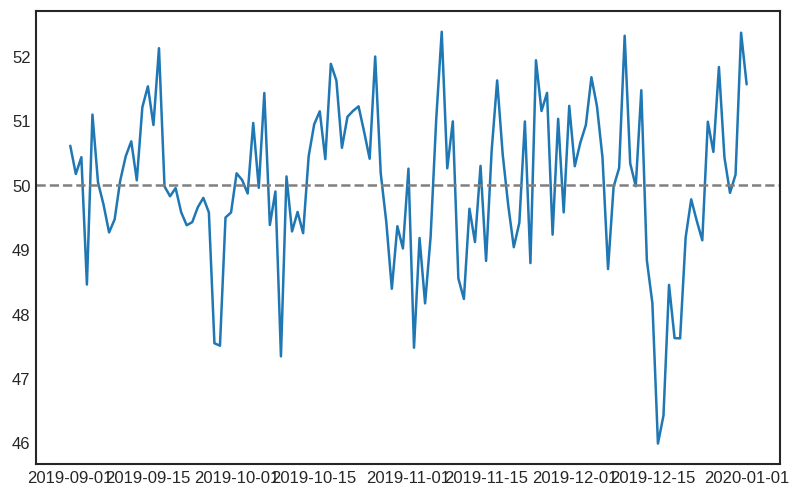

In [11]:
fg(w = 8, h = 5)
plt.plot(series)
plt.axhline(mu, linestyle = '--', color = 'gray');

### ACF

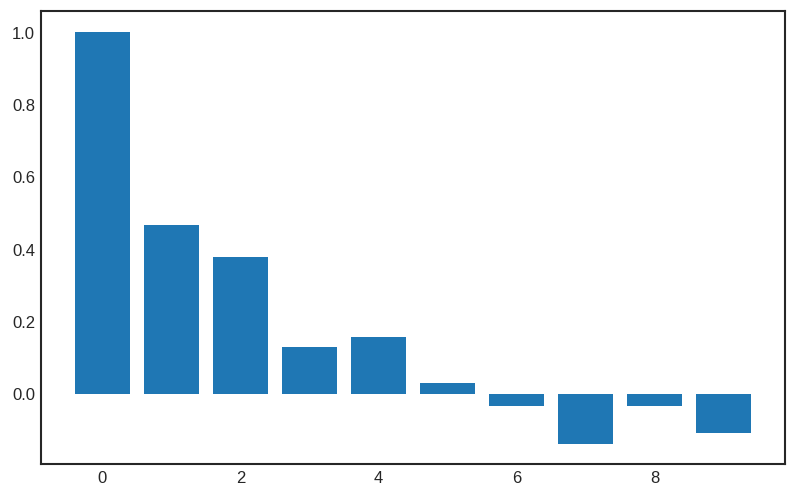

In [12]:
#it already respects the stationary condition
acf_vals = acf(series)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags]);

### PACF

<BarContainer object of 15 artists>

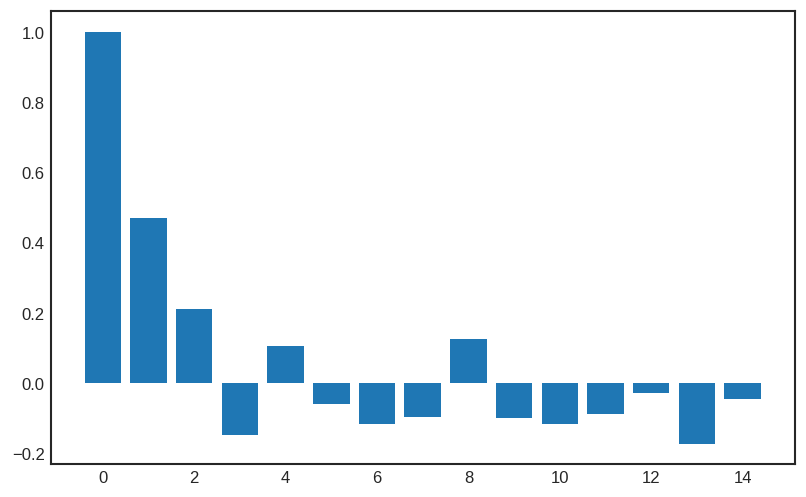

In [13]:
pacf_vals = pacf(series)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [14]:
train_end = datetime(2019,12,30)
test_end = datetime(2020,1,1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):test_end]

- order = (p,d,q)

    -p: autoregressive components
    
    -d: difference components (lags?)
    
    -q: moving average components
    
- Basta utilizar p e q como zero, para descartar os componentes da autoregressão

In [15]:
model = ARIMA(endog = train_data, order = (0,0,2))

In [16]:
model_fit = model.fit()

In [17]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -175.272
Date:                Mon, 03 Jan 2022   AIC                            358.544
Time:                        21:48:10   BIC                            369.727
Sample:                    09-01-2019   HQIC                           363.086
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9800      0.179    279.902      0.000      49.630      50.330
ma.L1          0.4206      0.077      5.432      0.000       0.269       0.572
ma.L2          0.4301      0.078      5.535      0.000       0.278       0.582
sigma2         1.0566      0.157      6.737      0.000       0.749       1.364
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.17
Prob(Q):                              0.97   Prob(JB):                         0.56
Heteroskedasticity (H):               1.73   Skew:                            -0.15
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
pre_start_date = test_data.index[0]
pre_end_date = test_data.index[-1]

In [19]:
y_hat = model_fit.predict(start = pre_start_date, 
                          end = pre_end_date)

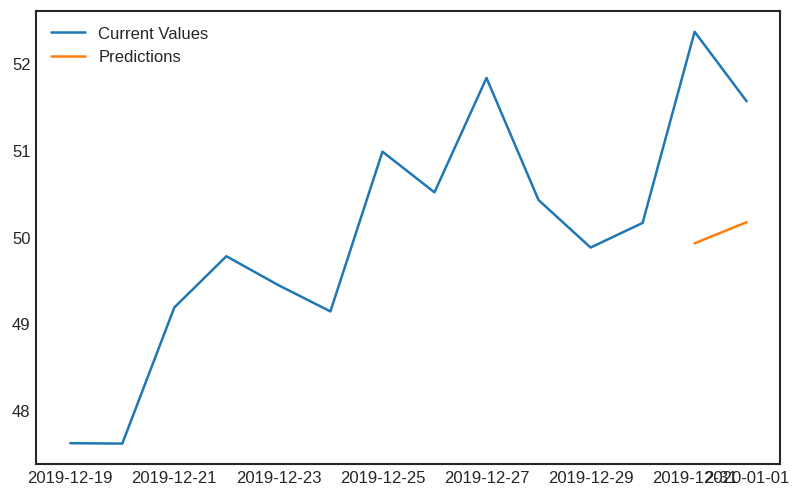

In [21]:
plt.plot(series[-14:], label = 'Current Values');
plt.plot(y_hat, label = 'Predictions');
plt.legend();
plt.show();

# From Scratch

- Como programar o Moving Average from Scratch

- https://medium.com/analytics-vidhya/arima-model-from-scratch-in-python-489e961603ce
- https://github.com/jinit24/ARIMA-Model/blob/master/ARIMA.ipynb

In [30]:
df = pd.read_csv('data/df.csv',parse_dates=True,index_col='date')
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['amount'])
df.columns=['value']

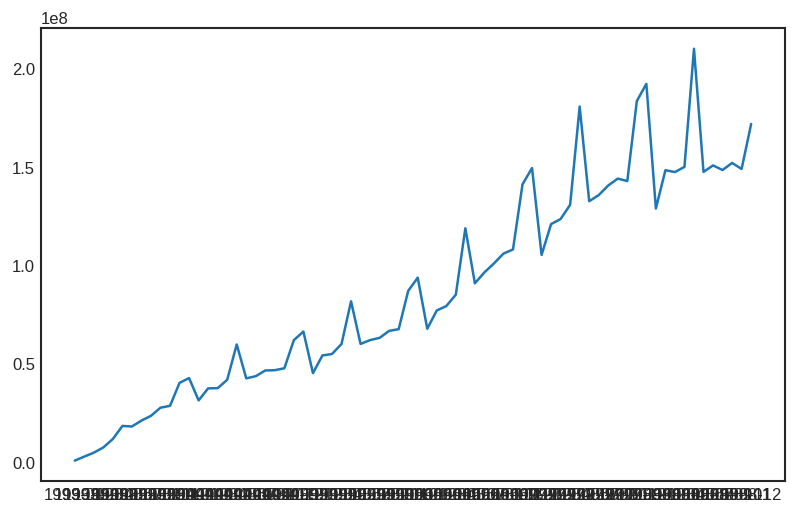

In [31]:
plt.plot(df['value'])

In [32]:
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")


In [33]:
df_testing = pd.DataFrame(np.log(df.value).diff().diff(12))
adf_check(df_testing.value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.225226609713747
p-value : 7.80717692014732e-06
Number of Lags Used : 3
Number of Observations Used : 55
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [35]:
df

,value
date,
1993-01,702157.6
1993-02,2726925.3
1993-03,4730318.6
1993-04,7378367.8
1993-05,11680753.4
...,...
1998-08,150639332.7
1998-09,148297693.4
1998-10,151889623.6


In [36]:
from sklearn.metrics import mean_squared_error
def AR(df:"pd.DataFrame",p:int,var:str):
    '''
    Recebe um dataframe, o input do time de lag p e a variável a qual sobre essa variação
    
    Retorna um dataframe com as novas variáveis com lag, um dataframe de teste para o modelo de 
    regressão linear, e os coeficientes da regressão assim como o erro
    '''
    df_temp = df.copy()

    #Generating the lagged p terms
    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp[var].shift(i)

    train_size = (int)(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    # Eliminar nulos
    df_train_2 = df_train.dropna()
    #X contains the lagged values ,hence we skip the first column
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
    #Y contains the value which must be predicted, the original one at t time (lag zero). It is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

    # Running linear regression to generate the coefficents of lagged terms
    # Phase space S(t) = (X(t), X(t-1), ..., X(t-p)) por exemplo
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # df_train_2[[var,'Predicted_Values']].plot()

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    # df_test[[var,'Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(df_test[var], df_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of p : ",p)
    return [df_train_2,df_test,theta,intercept,RMSE]

In [37]:
df_train_2,df_test,theta_ar,intercept,RMSE = AR(df,2,var='value')

The RMSE is : 28002638.93512278 , Value of p :  2


In [38]:
df_train_2.sample(5)
df_test.sample(5)
print('theta:\n',theta_ar)
print('intercept:\n',intercept)
print('RSME:\n',RMSE)

,value,Shifted_values_1,Shifted_values_2,Predicted_Values
date,,,,
1993-07,18021294.7,18291948.9,11680753.4,2.171935e+07
1994-04,37491620.6,37383802.6,31281776.7,4.009032e+07
1995-04,54844143.6,54113431.3,45126076.7,5.505526e+07
1996-06,118709525.0,84998109.4,79176075.7,8.557014e+07
1994-02,31281776.7,42592232.5,40212608.4,4.632080e+07


,value,Shifted_values_1,Shifted_values_2,Predicted_Values
date,,,,
1997-11,142695523.3,143934150.5,140446254.2,1.425401e+08
1998-11,148842093.6,151889623.6,148297693.4,1.500876e+08
1998-06,209902026.5,149884936.1,147273342.6,1.485102e+08
1998-05,149884936.1,147273342.6,148188410.7,1.472203e+08
1998-01,192082358.2,183333941.9,142695523.3,1.674604e+08


theta:
 [[0.61308291]
 [0.34008845]]
intercept:
 [6532381.95710405]
RSME:
 28002638.93512278


## Residuals

In [39]:
df_c = pd.concat([df_train_2,df_test])

In [40]:
df_c

,value,Shifted_values_1,Shifted_values_2,Predicted_Values
date,,,,
1993-03,4730318.6,2726925.3,702157.6,8.443009e+06
1993-04,7378367.8,4730318.6,2726925.3,1.035986e+07
1993-05,11680753.4,7378367.8,4730318.6,1.266466e+07
1993-06,18291948.9,11680753.4,7378367.8,1.620295e+07
1993-07,18021294.7,18291948.9,11680753.4,2.171935e+07
...,...,...,...,...
1998-08,150639332.7,147337119.2,209902026.5,1.682475e+08
1998-09,148297693.4,150639332.7,147337119.2,1.489944e+08
1998-10,151889623.6,148297693.4,150639332.7,1.486819e+08


In [41]:
df_c = pd.concat([df_train_2,df_test])
res = pd.DataFrame()
res['Residuals'] = df_c.value - df_c.Predicted_Values

In [42]:
res

,Residuals
date,
1993-03,-3.712690e+06
1993-04,-2.981487e+06
1993-05,-9.839065e+05
1993-06,2.088999e+06
1993-07,-3.698058e+06
...,...
1998-08,-1.760817e+07
1998-09,-6.967412e+05
1998-10,3.207763e+06


### Utilização dos valores residuais
Utilizamos os valores residuais, ou seja, dos erros, de quanto o modelo errou 


In [44]:
q = 2
for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

train_size = (int)(0.8 * res.shape[0])

res_train = pd.DataFrame(res[0:train_size])
res_test = pd.DataFrame(res[train_size:res.shape[0]])

res_train_2 = res_train.dropna()
X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

In [46]:
res_train_2.head()

,Residuals,Shifted_values_1,Shifted_values_2
date,,,
1993-05,-9.839065e+05,-2.981487e+06,-3.712690e+06
1993-06,2.088999e+06,-9.839065e+05,-2.981487e+06
1993-07,-3.698058e+06,2.088999e+06,-9.839065e+05
1993-08,-2.772999e+06,-3.698058e+06,2.088999e+06
1993-09,-2.114920e+06,-2.772999e+06,-3.698058e+06


In [47]:
def MA(res:"pd.DataFrame",q:int):
    
    '''
    Aplica-se uma regressão linear nos resíduos da auto regressão com p = 2
    A parte de moving average será uma tentativa de previsão do erro, ou seja, dos resíduos
    '''

    for i in range(1,q+1):
        res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

    train_size = (int)(0.8 * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()
    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # res_train_2[['Residuals','Predicted_Values']].plot()

    X_test = res_test.iloc[:,1:].values.reshape(-1,q)
    res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    res_test[['Residuals','Predicted_Values']].plot()

    from sklearn.metrics import mean_squared_error
    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of q : ",q)
    return [res_train_2,res_test,theta,intercept,RMSE]

The RMSE is : 27090418.21282145 , Value of q :  2


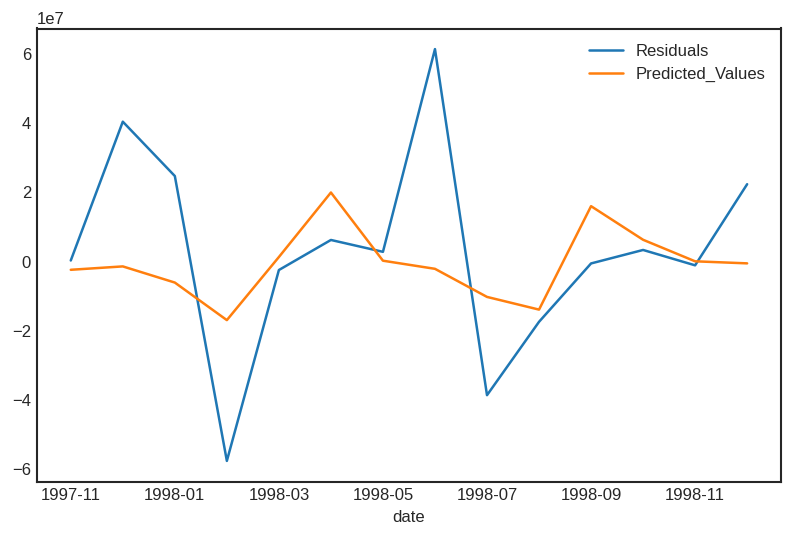

In [48]:
df_train_2,df_test,theta_res,intercept,RMSE = MA(res,2)

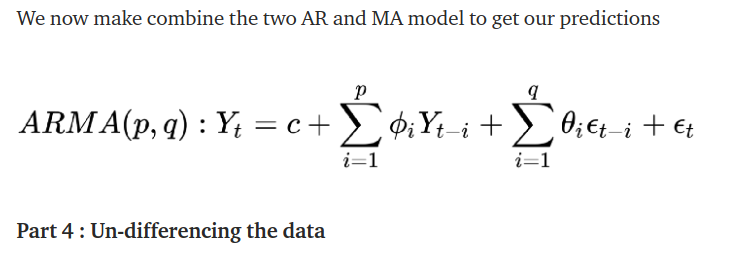

In [49]:
# AutoRegression Part
theta_ar 
# Moving Average Part
theta_res

array([[0.61308291],
       [0.34008845]])

array([[-0.15803796],
       [-0.33239089]])